<a href="https://colab.research.google.com/github/ksanjeevan/fauxgrad/blob/master/fauxgrad_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/ksanjeevan/fauxgrad.git

  Cloning https://github.com/ksanjeevan/fauxgrad.git to /tmp/pip-req-build-itwcvjzw
  Running command git clone -q https://github.com/ksanjeevan/fauxgrad.git /tmp/pip-req-build-itwcvjzw
  Created wheel for fauxgrad: filename=fauxgrad-0.1-py3-none-any.whl size=3578 sha256=8b2a855d2b338954034d05a7ed6bf251f8f86291ab3b57c49241b6a8318c58c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-ou4gabbq/wheels/9f/11/5a/5ac35f8c3006943a4779bfea0551c188a7cb323fdacb1a49a9
Successfully built fauxgrad


In [2]:
def generate_circles(N):
    from sklearn.datasets import make_circles
    X, Y = make_circles(n_samples=N, factor=.4, noise=.11)
    return X, Y.reshape(-1,1)


def vizualize_plot(X, m, title=None):
    resolution = 100
    xmin, xmax = X[:,0].min(), X[:,0].max()
    ymin, ymax = X[:,1].min(), X[:,1].max()

    x = np.linspace(xmin, xmax, resolution)
    y = np.linspace(ymin, ymax, resolution)
    xx, yy = np.meshgrid(x, y)

    d = np.stack([xx, yy], axis=2).reshape(-1,2)
    
    z = np.array([m([Value(d[0]), Value(d[1])])[0].val for d in d]).reshape(resolution, resolution)
    
    #plt.contourf(x,y,z, alpha=0.4, cmap='RdYlBu')
    #plt.scatter(X[:,0], X[:,1], c=np.squeeze(Y), cmap='bwr_r', s=30, alpha=0.6)
    plt.contourf(x,y,z, alpha=0.4, cmap='plasma')
    plt.scatter(X[:,0], X[:,1], c=np.squeeze(Y), cmap='binary', s=30, alpha=0.6)

    ax = plt.gca()
    ax.set_facecolor((0.95, 0.95, 0.95))
    if title is not None: ax.set_title(title)
    plt.axis('off')
    plt.show()

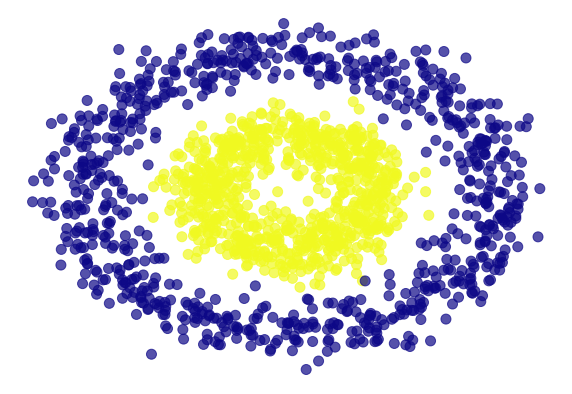

In [3]:
import numpy as np

np.random.seed(23)

X, Y = generate_circles(1600)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.scatter(X[:,0], X[:,1], c=np.squeeze(Y), cmap='plasma', s=100, alpha=0.7)
ax = plt.gca()
ax.set_facecolor((0.95, 0.95, 0.95))
plt.axis('off'); plt.show()

In [4]:
from fauxgrad import Linear, Value


class MyNet:
    
    def __init__(self):
        self.l1 = Linear(2, 15, 'relu')
        self.l2 = Linear(15, 1, 'sigmoid')
        
    def __call__(self, x):
        x = self.l1(x)
        x = self.l2(x)
        return x

    def parameters(self):
        return self.l1.parameters() + self.l2.parameters()


def nll_loss(pred, target):
    ret = [-p.log() if t == 1 else -(-p+1).log() for p, t in zip(pred, target)]
    return sum(ret)

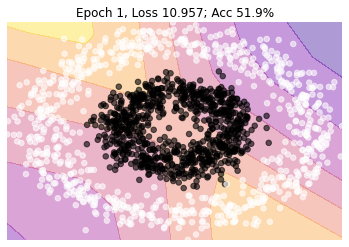

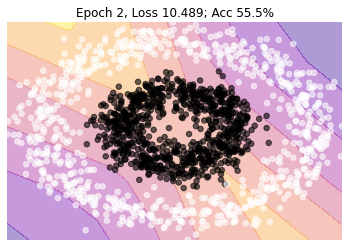

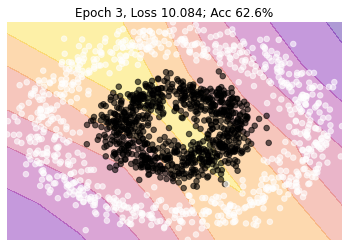

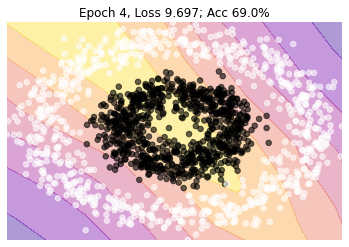

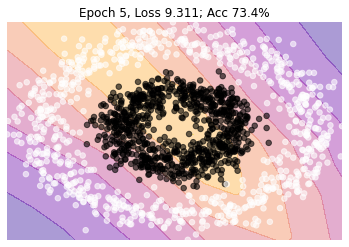

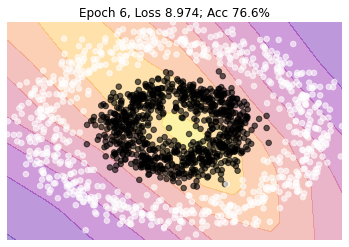

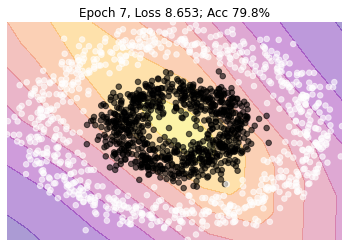

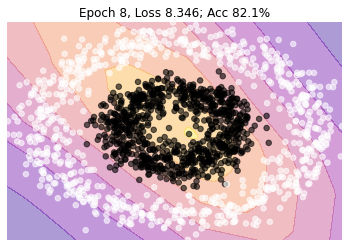

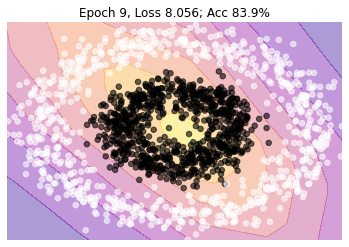

In [7]:
m = MyNet()

data = X.reshape(100, 16, 2) 
labels = Y.reshape(100, 16)

iters, batch_size = data.shape[:2]

from fauxgrad.optim import SGD
epochs = 9
lr = 0.001
opt = SGD(m.parameters(), lr=lr)

for epoch in range(1, epochs+1):
    losses = []; accs = []
    
    for i in range(iters):
        x = [[Value(d[0]), Value(d[1])] for d in data[i]]

        opt.zero_grad()
        yhat = [m(datum)[0] for datum in x]

        loss = nll_loss(yhat, labels[i])
        loss.backward()
        
        losses.append(loss.val)
        accs.extend([int(y.val>0.5)==l for y, l in zip(yhat, labels[i])])

        opt.step()
    title = 'Epoch %d, Loss %.3f; Acc %.1f%%'%(epoch,
                                               sum(losses)/len(losses), 
                                               100*sum(accs)/len(accs))
    vizualize_plot(X, m, title=title)